# CS684 - Final Project
## Self supervised disparity estimation with perceptual loss

#### Rowan Dempster and Gustavo Sutter

### Abstract

Self supervised learning (SSL) can be applied to disparity estimation by reconstructing the left image by inverse warping the right image, taking care to apply an occlusion mask, and generating a reconstruction loss. However, even under a ground truth disparity map, the pixels of the reconstructed left image may not perfectly match the pixels of the observed left image due to shadows, reflections, etc.. which change between the left and right view points [1]. Thus, we should not expect a pixel based reconstruction loss to converge to the desired solution for such surfaces where the “color consistency” assumption between view points does not hold. 

In this report we study the above problem, first examining motivating examples of cases where the color consistency assumption does not hold, and presenting a possible solution based on “perceptual loss” [2]. We then implement our own SSL training pipeline with disparity estimation model based on [3], and provide results of a large suite of experiments which analyze the efficacy of different loss function designs. We found that the usage of perceptual loss does decrease the End-Point-Error (EPE) metric, but still struggles to correctly estimate disparity of surfaces where the color consistency assumption does not hold. 

### Group Member Contributions 

**Rowan Dempster**:
- Implemented perceptual loss using VGG16
- Implemented occlusion masking
- Performed loss funtion visualizations

**Gustavo**:
- Organized project modules
- Implemented training script
- Implemented report notebook

### Code Libraries
- **[IRS](https://github.com/HKBU-HPML/IRS)**: Dataset that we use for SSL training. Also implements the disparity network model that we use to experiment with different loss functions.

In [1]:
# Create IRS/lists/IRS_metal_test.list for our usage
from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tabulate
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import sys
sys.path.append('extlibs/')

from IRS.dataloader.IRSLoader import IRSDataset
from IRS.networks.DispNetC import DispNetC
from IRS.losses.multiscaleloss import EPE

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda:0'
DATA_DIR = "/data"
VALIDATION_LIST = 'extlibs/IRS/lists/IRS_restaurant_metal_test.list'

### Dataset

The IRS dataset contains rectified stereo pairs of indoor simulated environments, as well as ground truth disparity maps

In [3]:
# Loading the dataset
dataset = IRSDataset(txt_file=VALIDATION_LIST, 
                     root_dir=DATA_DIR, 
                     phase='visualize')

Text(0, 0.5, 'True disparity')

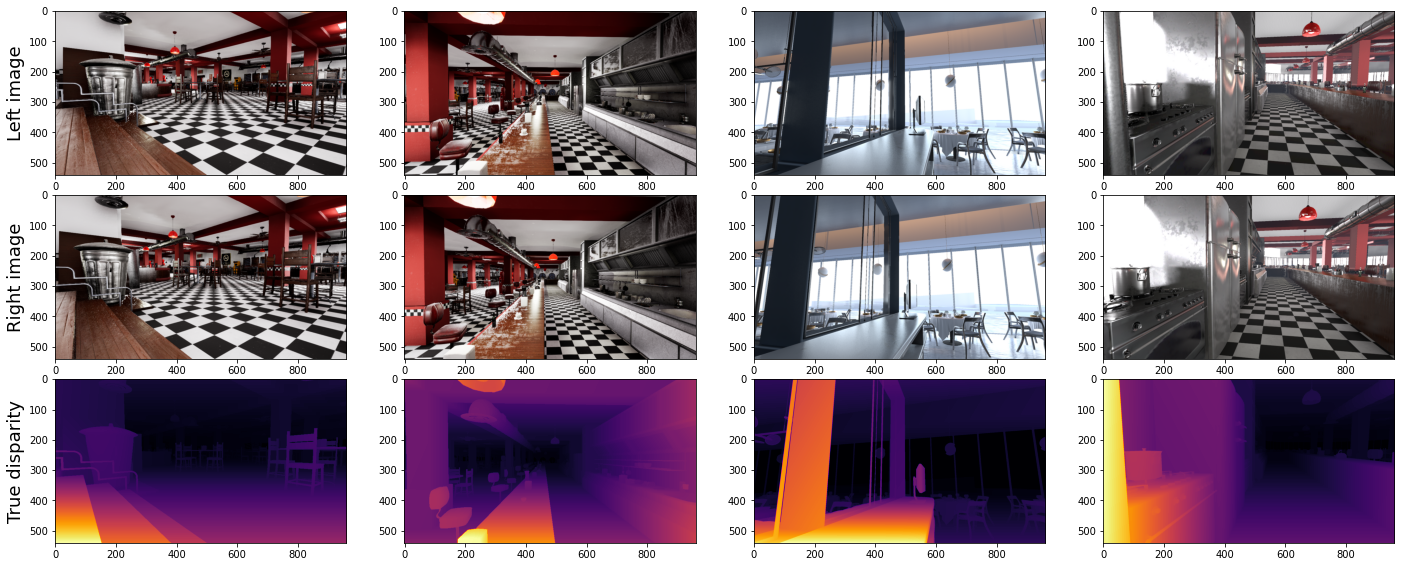

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 10))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    ax[0, i].imshow(sample['img_left'].permute(1, 2, 0))
    ax[1, i].imshow(sample['img_right'].permute(1, 2, 0))
    ax[2, i].imshow(sample['gt_disp'].permute(1, 2, 0), cmap='inferno')

ax[0, 0].set_ylabel('Left image', fontsize=18)
ax[1, 0].set_ylabel('Right image', fontsize=18)
ax[2, 0].set_ylabel('True disparity', fontsize=18)

### Unsupervised learning

We are tackling stereo disparity estimation as a unsupervised learning problem, which means that we are not interest in using the true disparity during the training phase. Therefore, during training the two views are the only data used to learn the structure of the scene. That is a much more realistic strategy, as in most applications collecting a real dataset with dense disparity maps requires specialized hardware and still exhibits some inperfections.

Reconstructing one of the views given the other can be used as supervision signal to replace the ground-truth disparitied. More concretely, the idea is that the disparity maps indicates how the pixels between the two images connect to each other. Therefore, given the left view $I^{L}$ we can use its predicted disparity $\hat{d}^L$ to create a reconstructed version of the left view reprojecting the right view, $\hat{I}^{L} = Repr(I^R, \hat{d}^L)$. The reprojection basically consists of shifting the pixels of the right images according the disparity, being careful about the disparity values to deal with occlusions. 

The following piece of code shows real images from the dataset and the resulting reconstruction

In [5]:
from mylibs.reconstruction import estimate_left

In [6]:
idx = 26
sample = dataset[idx]
im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']
im_l, im_r, disp = im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)

est_l = estimate_left(im_l, im_r, disp)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


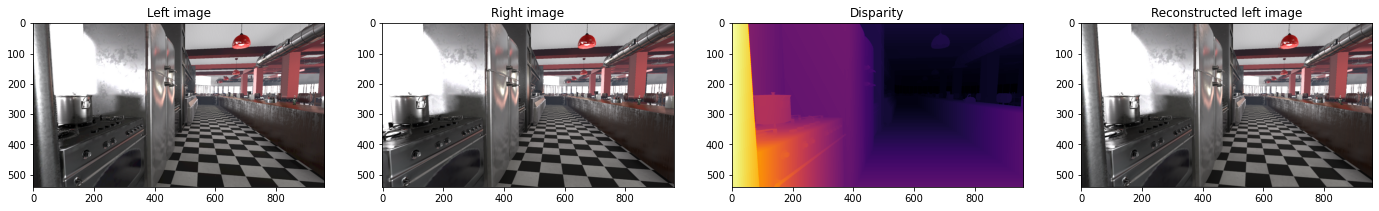

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

ax[0].imshow(im_l[0].permute(1, 2, 0))
ax[0].set_title('Left image')

ax[1].imshow(im_r[0].permute(1, 2, 0))
ax[1].set_title('Right image')

ax[2].imshow(disp[0].permute(1, 2, 0), cmap='inferno')
ax[2].set_title('Disparity')

ax[3].imshow(est_l[0].permute(1, 2, 0))
ax[3].set_title('Reconstructed left image');

### Loss function visualization

In order to see how the L1 loss fail on reflective surfaces let us analyze them using the ground-truth disparity to do reconstruction. As the ground-truth is being used one might expect that the loss will be zero, but as the following images demonstrate, that is not the case for the reflective surfaces.

Text(0, 0.5, 'Loss visualization')

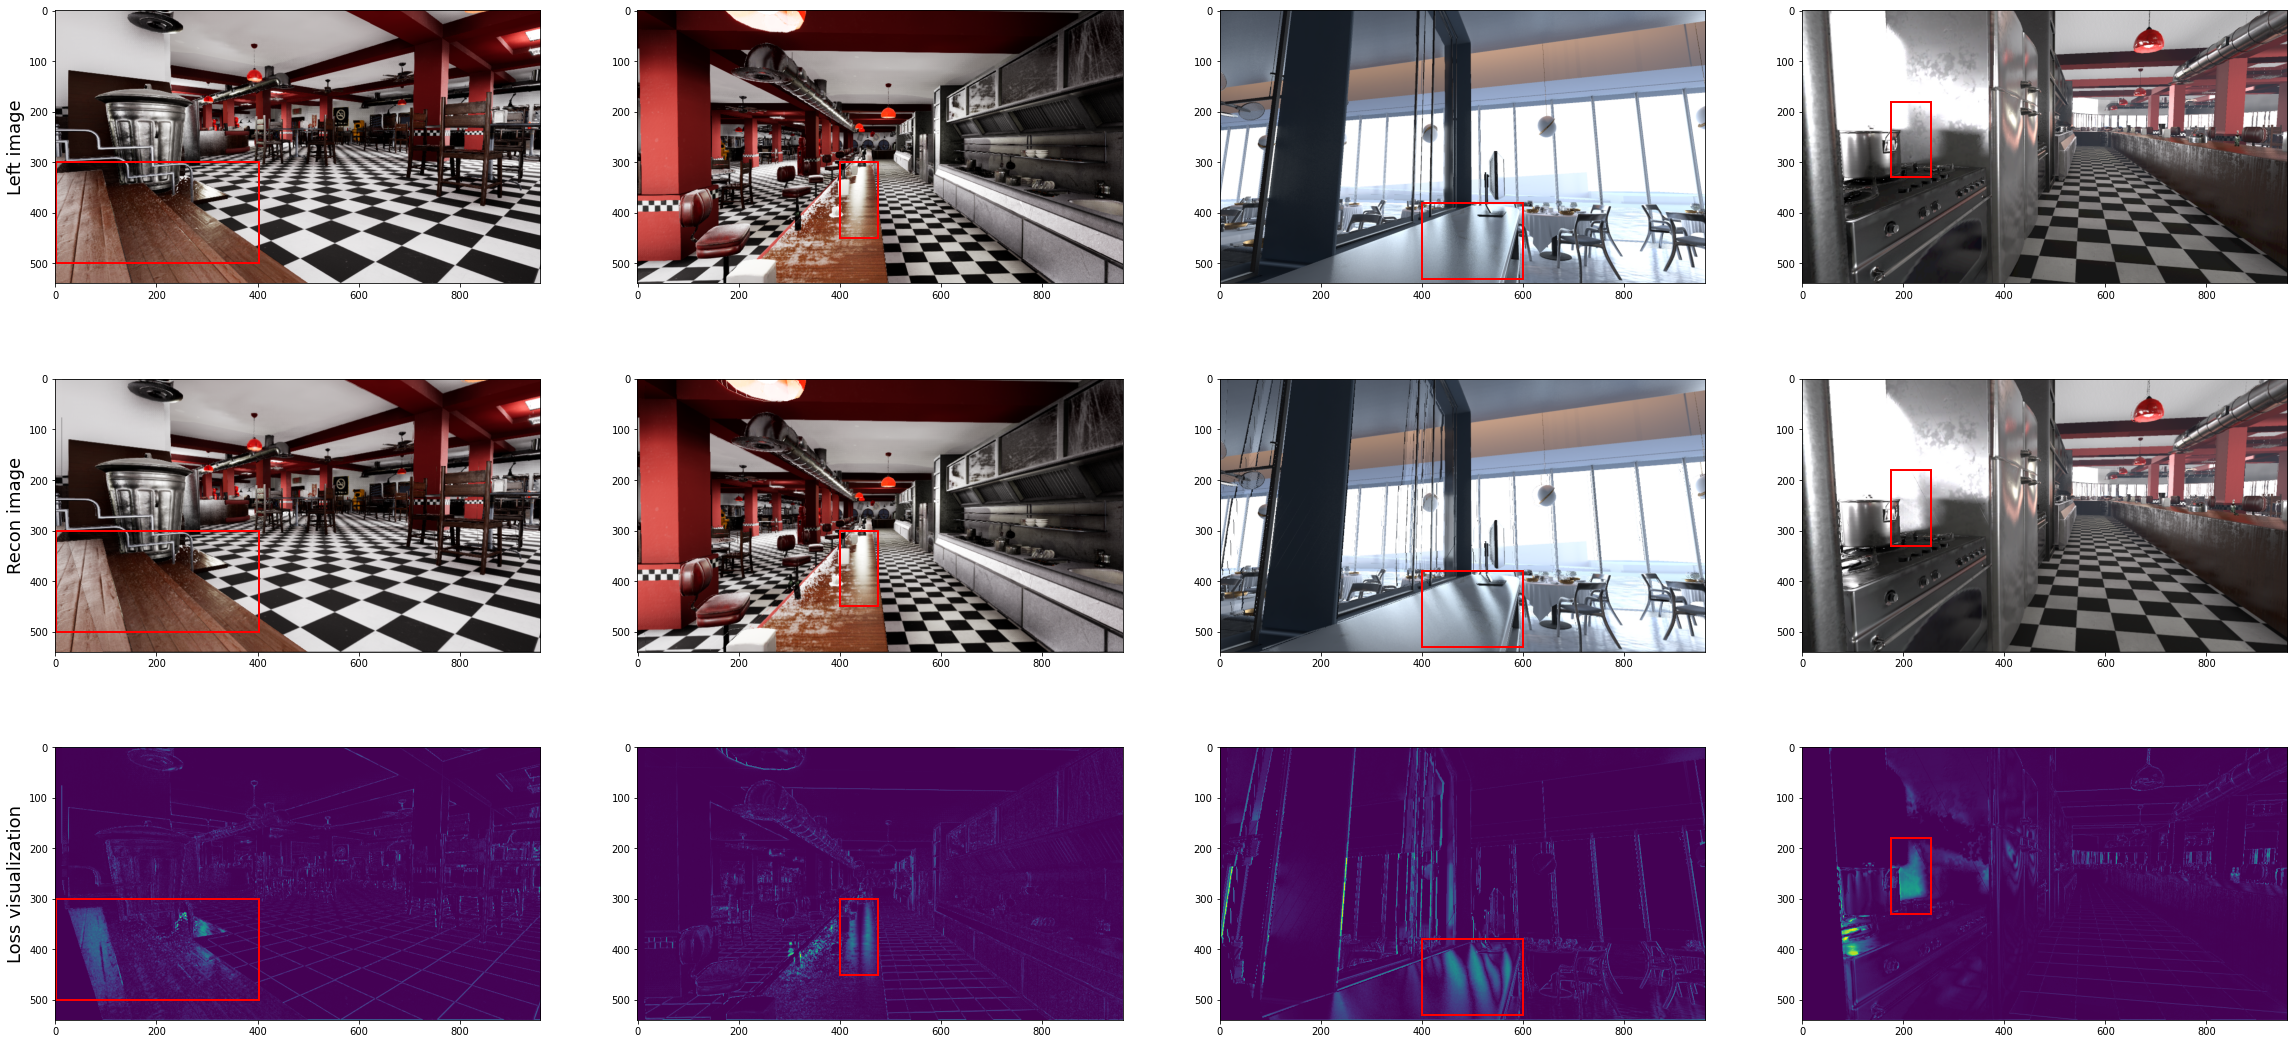

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(40, 20))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
rect_dict = {idx: 
    patches.Rectangle((box[0], box[1]), box[2], box[3], 
    linewidth=2, edgecolor='red', facecolor='none') 
    for idx, box in zip(selected_samples, [[2, 300, 400, 200], [400, 300, 75, 150], [400, 380, 200, 150], [175, 180, 80, 150]])
}
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    im_l, im_r, disp = sample['img_left'].to(DEVICE), sample['img_right'].to(DEVICE), sample['gt_disp'].to(DEVICE)
    ax[0, i].imshow(im_l.permute(1, 2, 0).cpu())
    ax[0, i].add_patch(deepcopy(rect_dict[idx]))
    est_l = estimate_left(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[1, i].imshow(est_l.permute(1, 2, 0).cpu())
    ax[1, i].add_patch(deepcopy(rect_dict[idx]))
    l1_loss = torch.abs(est_l - im_l).norm(dim=0,p=1)
    ax[2, i].imshow(l1_loss.cpu())
    ax[2, i].add_patch(deepcopy(rect_dict[idx]))

ax[0, 0].set_ylabel('Left image', fontsize=18)
ax[1, 0].set_ylabel('Recon image', fontsize=18)
ax[2, 0].set_ylabel('Loss visualization', fontsize=18)

An alternative to computing the L1 directly is to first extract features from the images, and then compare the features. That is referred as perceptual loss, and is usually done by passing the images through a pre-trained VGG16 and getting the activations of an intermediate layer or set of layers. The next figure demonstrates that by using such activations the loss behaves better on reflective regions.

In [9]:
from mylibs.losses import PerceptualLoss

Text(0, 0.5, 'Per Layer 4')

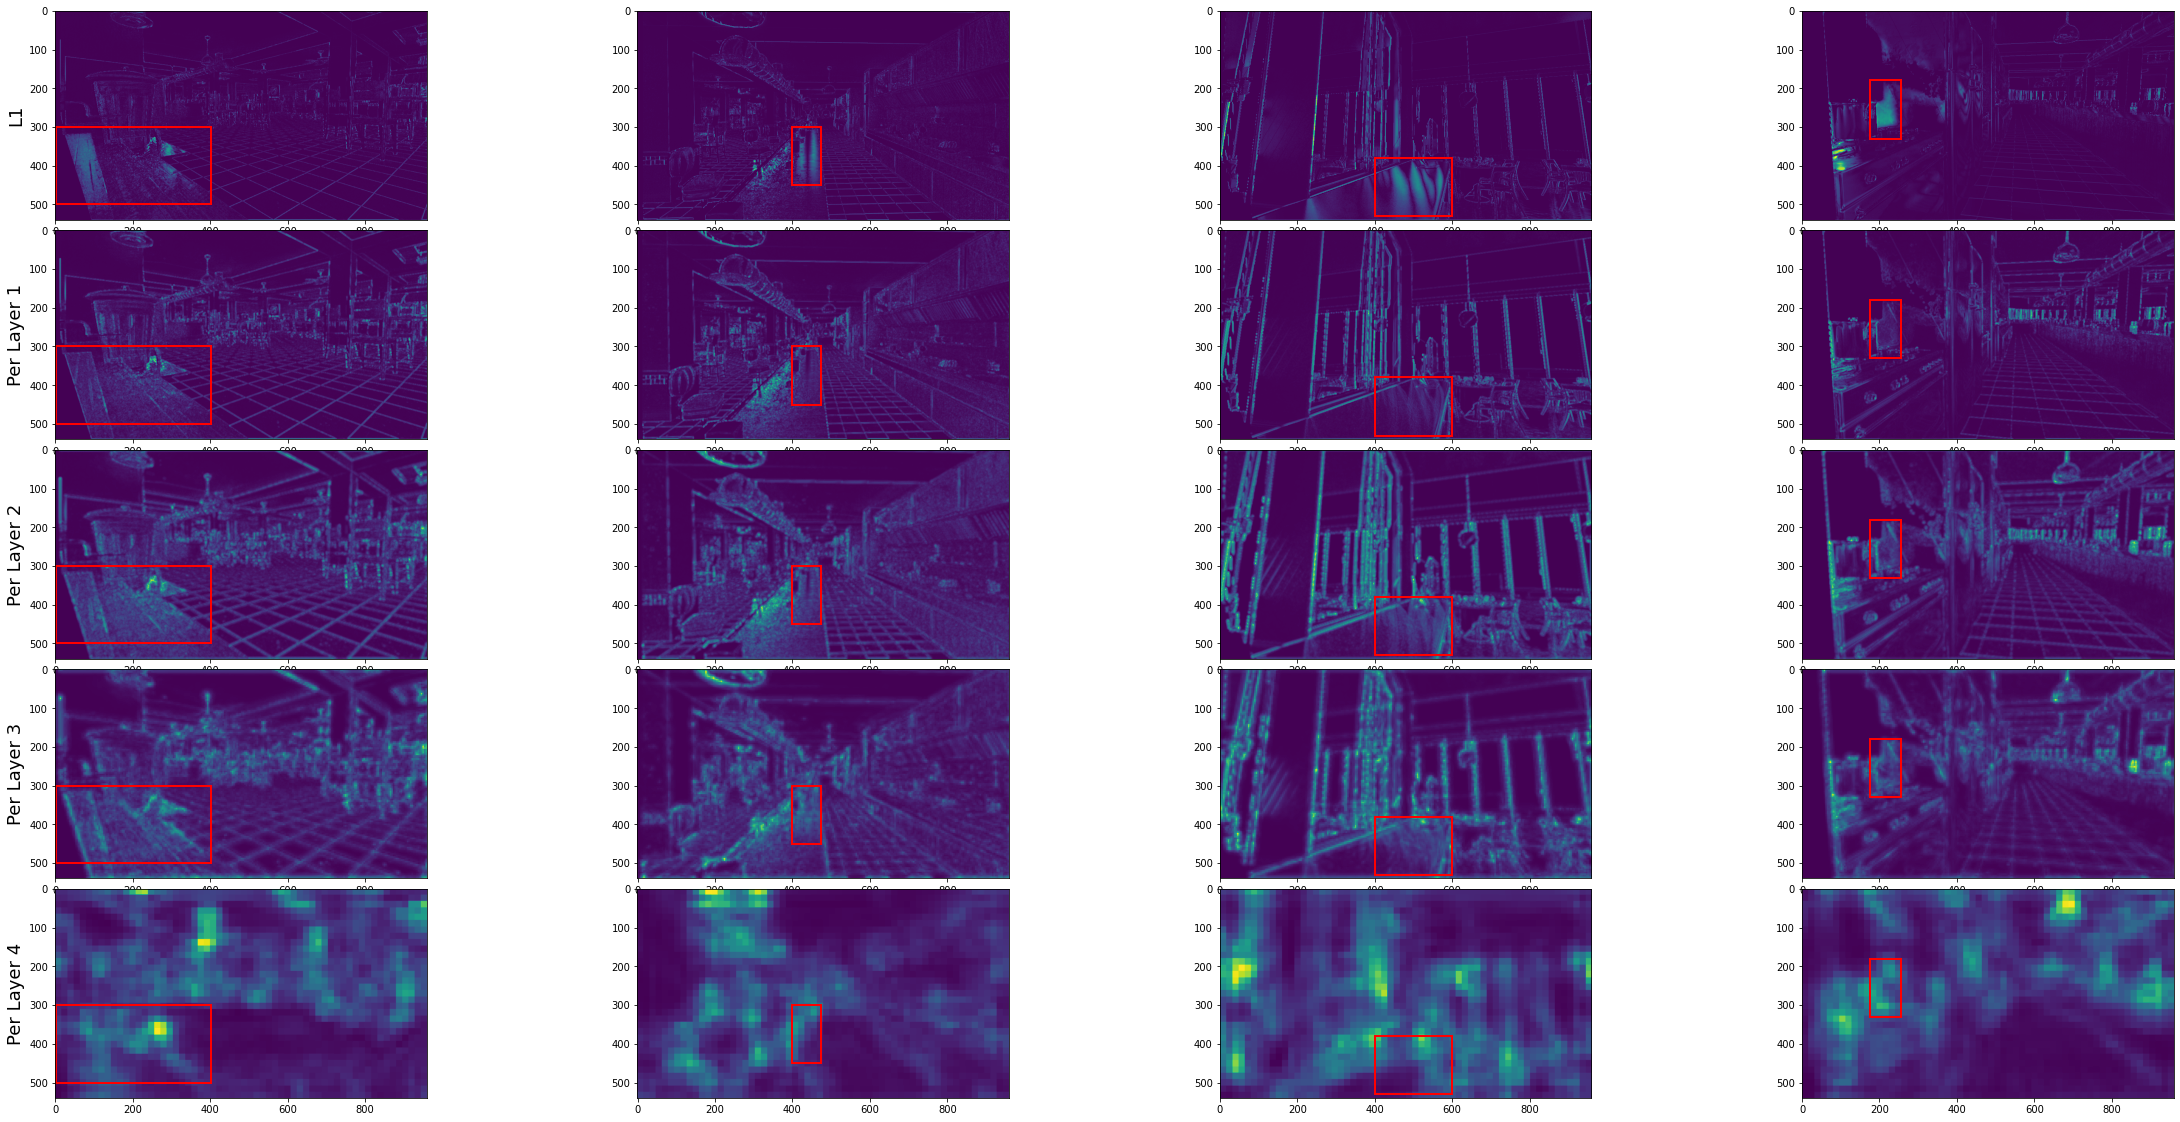

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(40, 20))
fig.subplots_adjust(hspace=0.05)

selected_samples = [8, 12, 15, 26]
rect_dict = {idx: 
    patches.Rectangle((box[0], box[1]), box[2], box[3], 
    linewidth=2, edgecolor='red', facecolor='none') 
    for idx, box in zip(selected_samples, [[2, 300, 400, 200], [400, 300, 75, 150], [400, 380, 200, 150], [175, 180, 80, 150]])
}
p1 = PerceptualLoss([PerceptualLoss.L1], DEVICE)
p2 = PerceptualLoss([PerceptualLoss.L2], DEVICE)
p3 = PerceptualLoss([PerceptualLoss.L3], DEVICE)
p4 = PerceptualLoss([PerceptualLoss.L4], DEVICE)
for i, idx in enumerate(selected_samples):
    sample = dataset[idx]
    im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']
    im_l, im_r, disp = im_l.to(DEVICE), im_r.to(DEVICE), disp.to(DEVICE)
    est_l = estimate_left(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()

    l1_loss = torch.abs(est_l - im_l).norm(dim=0,p=1)
    ax[0, i].imshow(l1_loss.cpu())
    ax[0, i].add_patch(deepcopy(rect_dict[idx]))
    
    p1_loss = p1(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0))
    ax[1, i].imshow(p1_loss[0].detach().cpu())
    ax[1, i].add_patch(deepcopy(rect_dict[idx]))
    
    p2_loss = p2(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[2, i].imshow(p2_loss.detach().cpu())
    ax[2, i].add_patch(deepcopy(rect_dict[idx]))
    
    p3_loss = p3(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[3, i].imshow(p3_loss.detach().cpu())
    ax[3, i].add_patch(deepcopy(rect_dict[idx]))
    
    p4_loss = p4(im_l.unsqueeze(0), im_r.unsqueeze(0), disp.unsqueeze(0)).squeeze()
    ax[4, i].imshow(p4_loss.detach().cpu())
    ax[4, i].add_patch(deepcopy(rect_dict[idx]))

ax[0, 0].set_ylabel('L1', fontsize=18)
ax[1, 0].set_ylabel('Per Layer 1', fontsize=18)
ax[2, 0].set_ylabel('Per Layer 2', fontsize=18)
ax[3, 0].set_ylabel('Per Layer 3', fontsize=18)
ax[4, 0].set_ylabel('Per Layer 4', fontsize=18)

### Experimental framework


We used the network architeture from IRS [3], it receives the two views concatened along the channel axis and outputs the predict disparity map. A large portion of our work was done on the study of different loss functions to the problem. We experimented with the following loss functions:

**L1 Loss**:

$$\mathcal{L}_{L1} = \sum_{i,j} |I^L_{ij} - \hat{I}^L_{ij}|$$

**Disparity smoothness loss**: 

$$\mathcal{L}_{smooth} = \sum_{i,j} |\nabla_x \hat{d}^L_{ij}| e^{-\nabla_x \hat{I}^L_{ij}} + |\nabla_y \hat{d}^L_{ij}| e^{-\nabla_y \hat{I}^L_{ij}}$$

**Perceptual loss**: 

$$\mathcal{L}_{per} = \sum_k \sum_{i,j} |\phi_k(I^L)_{ij} - \phi_k(\hat{I}^L)_{ij}|$$

(where $\phi_k(\cdot)$ is the output of the k-th layer of a VGG network)

In theory we should be able to apply a multiscale loss scheme, however due to computational constraints we calculated the loss on the final image resolution. 

First we explored the difference between $\mathcal{L}_{L1} + \mathcal{L}_{smooth}$ and several versions of $\mathcal{L}_{per}$, using various output layers combinations. After that we explored how to combine all losses experimenting with some sets of weights.

The models were trained using the complete set of restaurant scenes and evaluated only on the reflective subset of restaurants test set. Also due to computational constraints we were only able to fit batch sizes of 1 or 2 images depending on the experiment, which may have impacted our results.

### Results

Let us start by loading the models and their scores, followed by generating some test samples to be presented. The results of the models are shown both quantitatively, through a table of scores, and qualitatively, using real samples from the test set.

In [11]:
def load_model(path, device):
    state_dict = torch.load(path, map_location=device)
    state_dict, epe = state_dict['model'], state_dict['epe']
    model = DispNetC(batchNorm=False, input_channel=3, maxdisp=194).to(device)
    model.load_state_dict(state_dict)
    model = model.eval()
    return model, epe


def run_inference(net, im_l, im_r, scale_size, device):
    im_l, im_r = im_l.to(device), im_r.to(device)
    im_l, im_r = im_l.unsqueeze(0), im_r.unsqueeze(0)

    im_l = F.interpolate(im_l, scale_size, mode="bilinear")
    im_r = F.interpolate(im_r, scale_size, mode="bilinear")

    input = torch.cat((im_l, im_r), 1)       
    with torch.no_grad():
        pred_disp = net(input)[0]

    pred_disp = pred_disp.squeeze(0)
    pred_disp = pred_disp.cpu()
    
    return pred_disp

def run_validation(net, loader, device):
    net.eval()
    total = 0
    n = 0

    for batch in tqdm(loader):
        batch = {name: tensor.to(device) for name, tensor in batch.items()}
        left_input, right_input, target_disp = batch["img_left"], batch["img_right"], batch["gt_disp"]

        left_input = F.interpolate(left_input, loader.dataset.scale_size, mode="bilinear")
        right_input = F.interpolate(right_input, loader.dataset.scale_size, mode="bilinear")

        input = torch.cat((left_input, right_input), 1)       
        with torch.no_grad():
            disp = net(input)[0]

        # upsampling the predicted disparity map
        disp = nn.Upsample(size=target_disp.shape[2:], mode='bilinear')(disp)
        epe = EPE(disp, target_disp)

        # record loss and EPE
        total += epe.data.item()
        n += input.size(0)

    return total / n


def create_result_table(results):
    map_to_fig = {True: '✓', False: '✗'}
    results = [[map_to_fig[r] if type(r) == bool else r for r in res] for res in results]
    results = [[f'{r: .4f}' if type(r) == float else r for r in res] for res in results]
    results_table = tabulate.tabulate(results, headers=['L1', 'Perceptual', 'Smooth', 'EPE'], tablefmt='html', colalign= 4 * ["center"])
    return results_table

In [12]:
# Flag to indicate if the metric should be run again or just use the one saved with the model
RECOMPUTE_EPE = False

# Creating dataset and dataloader
dataset = IRSDataset(txt_file=VALIDATION_LIST, root_dir=DATA_DIR, phase='test', load_norm=False)
loader = DataLoader(dataset, batch_size=4, shuffle=False, pin_memory=True)

# Defining the list of experiments to be evaluated
configs = [
    {'path': '/project/L1_smooth001_lr_small_disp_fix_new/dispnet_epoch_10_BEST', 'l1': True, 'per': False, 'smooth': True},
    {'path': '/project/per_loss/dispnet_epoch_2_BEST', 'l1': False, 'per': 'Layer 1', 'smooth': False},
    {'path': '/project/per_loss_l12/dispnet_epoch_25_BEST', 'l1': False, 'per': 'Layers 1 and 2', 'smooth': False},
    {'path': '/project/ckpts/l123_prod/dispnet_epoch_3_BEST', 'l1': False, 'per': 'Layers 1, 2 and 3', 'smooth': False},
    {'path': '/project/ckpts/all_prod/dispnet_epoch_8_BEST', 'l1': False, 'per': 'Layers 1, 2, 3 and 4', 'smooth': False},
]

# Defining the samples to be used for inference
sample_idx_list = [50, 51]

In [13]:
# List to store the disparities produced by the models
inference_results = []

# Loading experiments weights and computing the evalutation metric
results = []
for config in configs:
    model, epe = load_model(config['path'], DEVICE)
    if RECOMPUTE_EPE:
        epe = run_validation(model, loader, DEVICE)
    
    disps = []
    for idx in sample_idx_list:
        sample = dataset[idx]
        im_l, im_r = sample["img_left"], sample["img_right"]
        disp = run_inference(model, im_l, im_r, dataset.scale_size, DEVICE)
        disps.append(disp)

    results.append([config['l1'], config['per'], config['smooth'], epe])
    inference_results.append(disps)


# Transpose list of results
inference_results = list(map(list, zip(*inference_results)))

# Creating a table with the results and displaying it
results_table = create_result_table(results)
results_table

/project/extlibs/IRS/networks/DispNetC.py:117: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(m.weight.data)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


'<table>\n<thead>\n<tr><th style="text-align: center;"> L1 </th><th style="text-align: center;">     Perceptual     </th><th style="text-align: center;"> Smooth </th><th style="text-align: center;">  EPE  </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: center;"> ✓  </td><td style="text-align: center;">         ✗          </td><td style="text-align: center;">   ✓    </td><td style="text-align: center;">12.7716</td></tr>\n<tr><td style="text-align: center;"> ✗  </td><td style="text-align: center;">      Layer 1       </td><td style="text-align: center;">   ✗    </td><td style="text-align: center;">4.5001 </td></tr>\n<tr><td style="text-align: center;"> ✗  </td><td style="text-align: center;">   Layers 1 and 2   </td><td style="text-align: center;">   ✗    </td><td style="text-align: center;">4.4282 </td></tr>\n<tr><td style="text-align: center;"> ✗  </td><td style="text-align: center;"> Layers 1, 2 and 3  </td><td style="text-align: center;">   ✗    </td><td style="text-align: center;">7.4574 </td></tr>\n<tr><td style="text-align: center;"> ✗  </td><td style="text-align: center;">Layers 1, 2, 3 and 4</td><td style="text-align: center;">   ✗    </td><td style="text-align: center;">8.1713 </td></tr>\n</tbody>\n</table>'

It is possible to notice that the models trained with the perceptual loss outperform the one that uses L1 and smoothness. On the other hand it is not related only to the number of VGG layers added to the loss, but to which layers are used. Let us observe some of the samples produced by the models:

In [14]:
def denormalize_img(im):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return im * std + mean 
    

def show_results_grid(im_l, im_r, gt_disp, results_disps, names, box=None):
    layout = [['im_l', 'd1', 'd2', 'd3', 'd4','d5'],
              ['im_r', 'd1', 'd2', 'd3', 'd4','d5']]

    fig, ax = plt.subplot_mosaic(layout, figsize=(35, 8))

    ax['im_l'].imshow(im_l.permute(1, 2, 0))
    ax['im_l'].set_title('Left image')
    ax['im_r'].imshow(im_r.permute(1, 2, 0))
    ax['im_r'].set_title('Right image')    

    keys = ['d1', 'd2', 'd3', 'd4','d5']
    disps = [gt_disp] + results_disps
    names = ['Ground-truth'] + names
    for key, disp, name in zip(keys, disps, names):
        ax[key].imshow(disp.permute(1, 2, 0), cmap='inferno')
        ax[key].set_title(name)
        if box != None:
            rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
            ax[key].add_patch(rect)

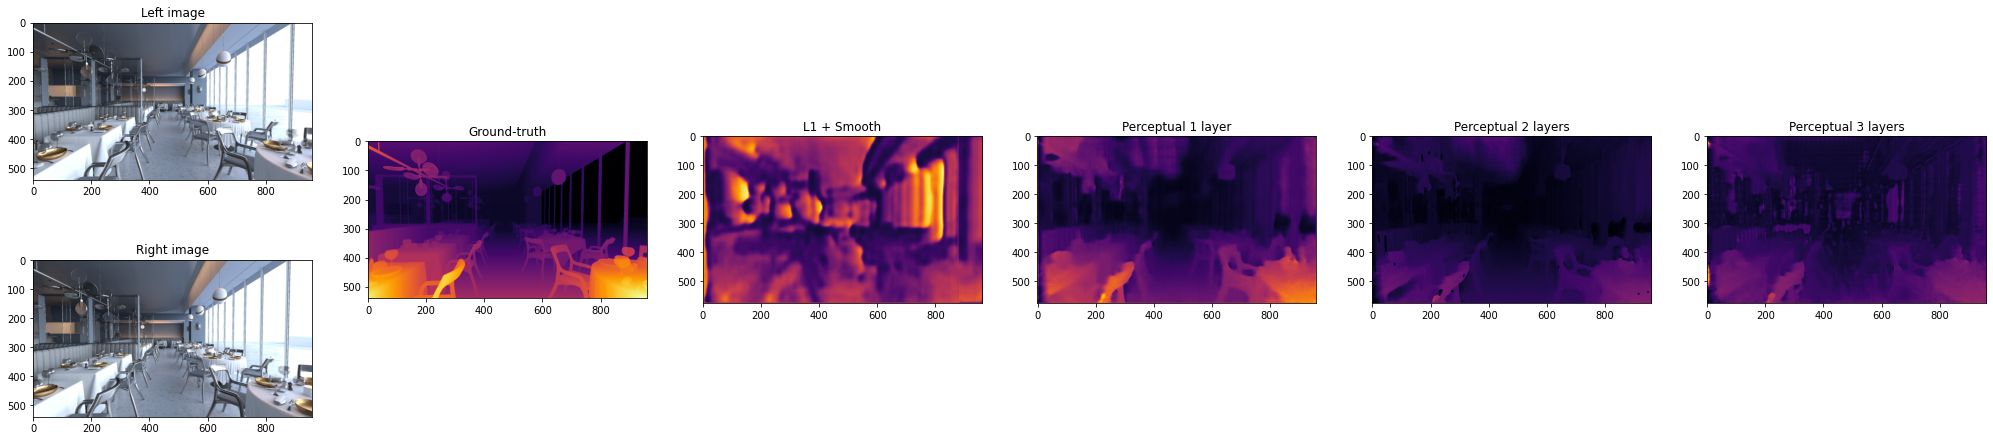

In [15]:
names = ['L1 + Smooth', 'Perceptual 1 layer', 'Perceptual 2 layers', 'Perceptual 3 layers', 'Perceptual 4 layers']

idx = 0
sample = dataset[sample_idx_list[idx]]
im_l, im_r, disp = sample["img_left"], sample["img_right"], sample['gt_disp']
im_l, im_r = denormalize_img(im_l), denormalize_img(im_r)

show_results_grid(im_l, im_r, disp, inference_results[idx], names)

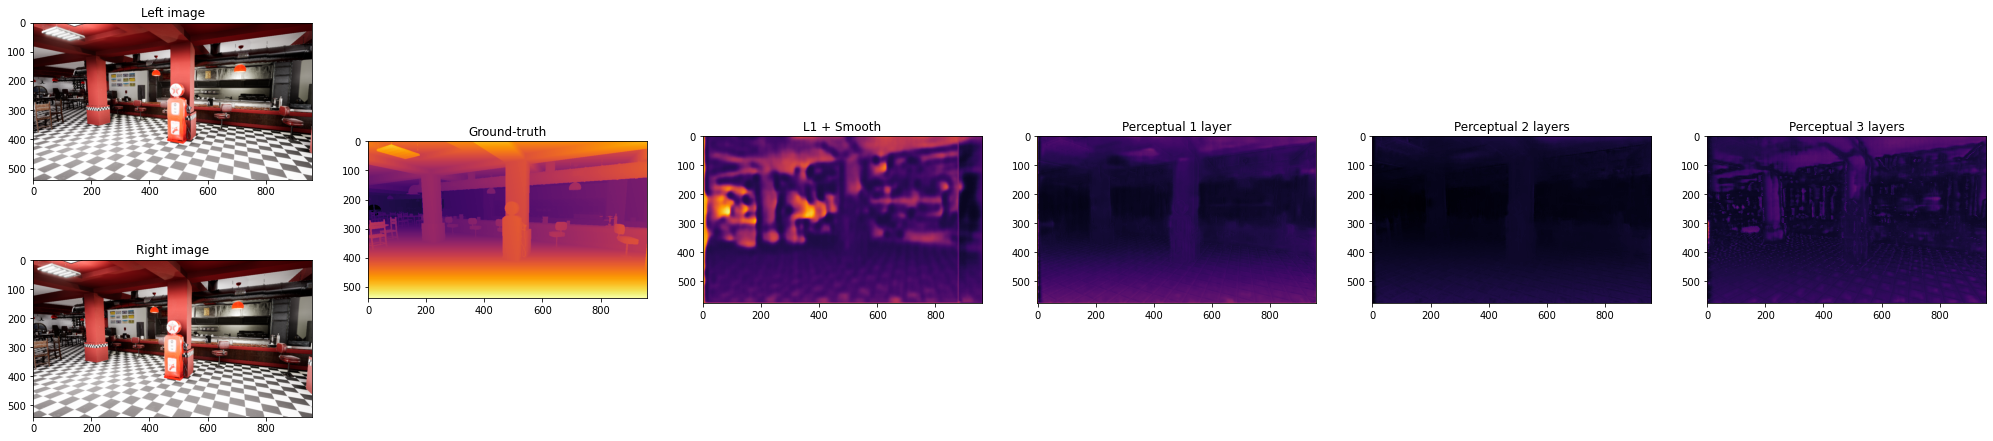

In [16]:
idx = 1

sample = dataset[sample_idx_list[idx]]
im_l, im_r, disp = sample["img_left"], sample["img_right"], sample['gt_disp']
im_l, im_r = denormalize_img(im_l), denormalize_img(im_r)

show_results_grid(im_l, im_r, disp, inference_results[idx], names)

It is clear that the result of the model without the perceptual loss is worse than the others.

Next, we present the results of a simple hyperparameter search for the loss weights in a model that combines the three losses. Of course, this task is very computationally intense, so the results that follow are more of a demonstration of how to investigate the optimal hyperparameters for the loss.

In [17]:
# Defining the list of experiments to be evaluated
configs = [
    {'path': '/project/ckpts/mix_half/dispnet_epoch_3_BEST', 'l1': 0.4995, 'per': 0.4995, 'smooth': 0.001},
    {'path': '/project/ckpts/mix_l1/dispnet_epoch_3_BEST', 'l1': 0.8991, 'per': 0.0999, 'smooth': 0.001},
    {'path': '/project/ckpts/mix_per/dispnet_epoch_1_BEST', 'l1': 0.0999, 'per': 0.8991, 'smooth': 0.001},
]

# List to store the disparities produced by the models
inference_results = []

# Loading experiments weights and computing the evalutation metric
results = []
for config in configs:
    model, epe = load_model(config['path'], DEVICE)
    if RECOMPUTE_EPE:
        epe = run_validation(model, loader, DEVICE)
    
    disps = []
    for idx in sample_idx_list:
        sample = dataset[idx]
        im_l, im_r = sample["img_left"], sample["img_right"]
        disp = run_inference(model, im_l, im_r, dataset.scale_size, DEVICE)
        disps.append(disp)

    results.append([config['l1'], config['per'], config['smooth'], epe])
    inference_results.append(disps)


# Transpose list of results
inference_results = list(map(list, zip(*inference_results)))

# Creating a table with the results and displaying it
results_table = create_result_table(results)
results_table

'<table>\n<thead>\n<tr><th style="text-align: center;">  L1  </th><th style="text-align: center;"> Perceptual </th><th style="text-align: center;"> Smooth </th><th style="text-align: center;"> EPE  </th></tr>\n</thead>\n<tbody>\n<tr><td style="text-align: center;">0.4995</td><td style="text-align: center;">   0.4995   </td><td style="text-align: center;"> 0.001  </td><td style="text-align: center;">7.8737</td></tr>\n<tr><td style="text-align: center;">0.8991</td><td style="text-align: center;">   0.0999   </td><td style="text-align: center;"> 0.001  </td><td style="text-align: center;">5.1138</td></tr>\n<tr><td style="text-align: center;">0.0999</td><td style="text-align: center;">   0.8991   </td><td style="text-align: center;"> 0.001  </td><td style="text-align: center;">6.6326</td></tr>\n</tbody>\n</table>'

Observing the results we can see that any of the combinations we have tried were able to match the results we got with the perceptual loss alone. However we have only tried a very limited set of weights, therefore further investigation would be necessary.

### Conclusion

On this project we demonstrated how the L1 loss can fail when the scenes exhibit reflective surfaces, which makes it problematic for a wide number of real-world applications. To help with this problem we analyzed how the perceptual loss behaves on the same type of scenes, demonstrating to be a more robust loss function for the task. After studying the losses on their own we proceeded to train several models varying the objective functions and confirmed that the perceptual loss produces better disparity estimations. Finally we did some exploration on how to combine all of the losses in a single objective, however any of the studied combinations was able to improve the results achived on the previous step.

There are several ways in which this project could be improved and extended. First of all, as this is a very computationally intensive task it would be ideal to have more computing power to increase the batch size and use a multiscale loss, which could improve generalization and lead to sharper disparity maps, respectively. In terms of more experiments, it would be interesting to investigate more on how to combine the multiple losses or even how to use those at different training stages, doing some kind of curriculum learning.

### References

[1] Gao, Huachen, et al. "PDANet: Self-supervised monocular depth estimation using perceptual and data augmentation consistency." Applied Sciences 11.12 (2021): 5383.

[2] Johnson, Justin, Alexandre Alahi, and Li Fei-Fei. "Perceptual losses for real-time style transfer and super-resolution." European conference on computer vision. Springer, Cham, 2016.

[3] Wang, Qiang, et al. "Irs: A large naturalistic indoor robotics stereo dataset to train deep models for disparity and surface normal estimation." arXiv preprint arXiv:1912.09678 (2019).